In [1]:
import numpy as np
import scipy

from FlagRep import FlagRep, chordal_distance

from matplotlib import pyplot as plt

from sklearn.manifold import MDS

In [2]:
## Small example

n=10 # n samples
p=4 # p features

# the feature hierarchy 
A1 = np.array([0])
A2 = np.array([0,1,2])
A3 = np.array([0,1,2,3])

# make a list the feature hierarchy
# this stores indices of the features
Aset = [A1, A2, A3]

# number of trials
n_trials = 1000



seed = 1
    
#set random seed
np.random.seed(seed)
    
# randomly generate a data matrix
D = np.zeros((n,p))
D[:,0] = np.random.normal(0,1,n) #d_1
D[:,1] = np.random.normal(0,2,n) #d_2
D[:,2] = 2*D[:,1]                #d_3
D[:,3] = np.random.normal(0,3,n) #d_4

FlagRep(D, Aset)

[3.77845963]


(array([[ 0.42989618, -0.23026975, -0.37209191],
        [-0.1619063 ,  0.71210966,  0.32908144],
        [-0.13978494,  0.01148532,  0.35686654],
        [-0.28396985, -0.0889147 ,  0.19645759],
        [ 0.22903715, -0.26967563,  0.44221216],
        [-0.60912089, -0.07633973, -0.32644602],
        [ 0.46177859,  0.47477257, -0.09226054],
        [-0.20145958,  0.18773793, -0.43926197],
        [ 0.08443629,  0.05626051, -0.11269339],
        [-0.06599789, -0.29910778,  0.26649994]]),
 array([1, 2, 3]))

In [78]:
# grass pasture = 5
# corn notill = 2
# data from https://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes#Indian_Pines


data = scipy.io.loadmat('../data/Indian_pines.mat')
labels = scipy.io.loadmat('../data/Indian_pines_gt.mat')

In [93]:
class1 = 5
class2 = 2

In [94]:
idx = (labels['indian_pines_gt'] == class1) |  (labels['indian_pines_gt'] == class2)

In [95]:
sel_data = data['indian_pines'][idx]
sel_labels = labels['indian_pines_gt'][idx]

In [96]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# sel_data = ss.fit_transform(sel_data)

In [122]:
np.random.seed = 420

Aset = [np.arange(40),np.arange(140),np.arange(220)]

Xs = []
fl_types = []
k=50
for id in [class1,class2]:
    idx = sel_labels == id
    for i in range(30):
        x_sel = sel_data[idx]
        x = x_sel[np.random.randint(len(x_sel), size = k),:]
        X, fl_type = FlagRep(x,Aset, eps_rank=3000)
        Xs.append(X)
        fl_types.append(fl_type)


[4.81610826e+04 8.12477172e+02 6.53305340e+01 6.11326746e+01
 5.80260541e+01 5.53948666e+01 5.28747096e+01 5.02351578e+01
 4.78021849e+01 4.56183180e+01 4.37470006e+01 4.34594925e+01
 4.05141967e+01 3.86329241e+01 3.62833009e+01 3.39329347e+01
 3.30918093e+01 3.28404910e+01 3.07141704e+01 2.85459579e+01
 2.73316188e+01 2.51310452e+01 2.48867303e+01 2.30279886e+01
 2.03700202e+01 1.98344510e+01 1.90541629e+01 1.78253294e+01
 1.66679297e+01 1.58615229e+01 1.46174176e+01 1.34286965e+01
 1.19537103e+01 9.99781717e+00 8.08079891e+00 8.02208867e+00
 7.55202307e+00 5.27470173e+00 4.55179217e+00 4.03093246e+00]
[4.78854548e+04 7.54062228e+02 6.27007658e+01 6.02115377e+01
 5.44752999e+01 5.37231088e+01 5.28726352e+01 5.05969651e+01
 4.71271374e+01 4.48001733e+01 4.37759068e+01 4.19837911e+01
 4.07189572e+01 3.85755063e+01 3.67132305e+01 3.55492700e+01
 3.28218567e+01 3.24297839e+01 3.03940024e+01 2.89569634e+01
 2.76835870e+01 2.60080621e+01 2.53336236e+01 2.34541244e+01
 2.31136661e+01 2.26894

In [123]:
max_dim = np.max(np.vstack(fl_types))

In [124]:
fl_types

[array([1, 5]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 5]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 5]),
 array([1, 4]),
 array([1, 5]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 5]),
 array([1, 4]),
 array([1, 5]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 4]),
 array([1, 5]),
 array([1, 6]),
 array([1, 6]),
 array([1, 7]),
 array([1, 6]),
 array([1, 6]),
 array([1, 5]),
 array([1, 6]),
 array([1, 6]),
 array([1, 6]),
 array([1, 5]),
 array([1, 7]),
 array([1, 6]),
 array([1, 6]),
 array([1, 7]),
 array([1, 6]),
 array([1, 5]),
 array([1, 5]),
 array([1, 6]),
 array([1, 6]),
 array([1, 6]),
 array([1, 6]),
 array([1, 6]),
 array([1, 6]),
 array([1, 5]),
 array([1, 6]),
 array([1, 5]),
 array([1, 6]),
 array([1, 7]),
 array([1, 6]),
 array([1, 7])]

In [125]:
p = len(fl_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = Xs[i]
        y = Xs[j]
        fl_type_x = fl_types[i]
        fl_type_y = fl_types[j]
        Bs_x = [np.arange(fl_type_x[0]),np.arange(fl_type_x[0]+1,fl_type_x[1])]
        Bs_y = [np.arange(fl_type_y[0]),np.arange(fl_type_y[0]+1,fl_type_y[1])]
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist
        

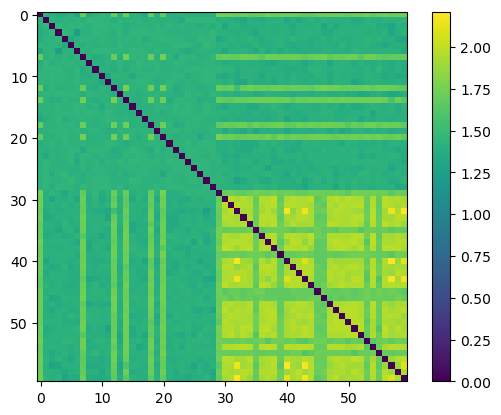

In [126]:
plt.imshow(dist_mat)
plt.colorbar()

/home/nate/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


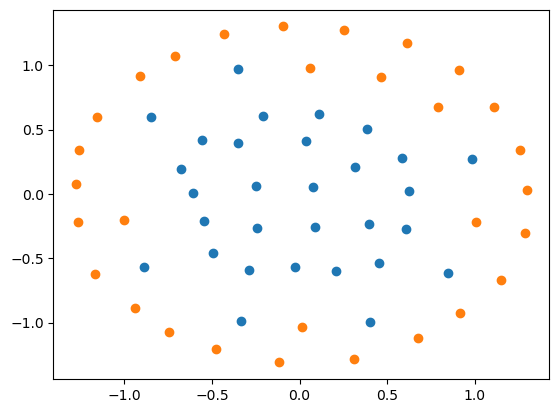

In [127]:

mds = MDS(n_components=2,dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

plt.scatter(vis_data[:p//2,0],vis_data[:p//2,1], color = 'tab:blue')
plt.scatter(vis_data[p//2:,0],vis_data[p//2:,1], color = 'tab:orange')

In [128]:
n_sing_vals = max_dim

np.random.seed = 420

Xs = []
fl_types = []
k=100
for id in [class1,class2]:
    idx = sel_labels == id
    for i in range(30):
        x_sel = sel_data[idx]
        x = x_sel[np.random.randint(len(x_sel), size = k),:]
        U,_,_ = np.linalg.svd(x, full_matrices=False)
        Xs.append(U[:,:n_sing_vals])
        fl_types.append(list(np.arange(1,n_sing_vals+1)))

In [129]:
p = len(fl_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = Xs[i]
        y = Xs[j]
        fl_type_x = fl_types[i]
        fl_type_y = fl_types[j]
        Bs_x = [np.arange(fl_type_x[0]),np.arange(fl_type_x[0]+1,fl_type_x[1])]
        Bs_y = [np.arange(fl_type_y[0]),np.arange(fl_type_y[0]+1,fl_type_y[1])]
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist
        

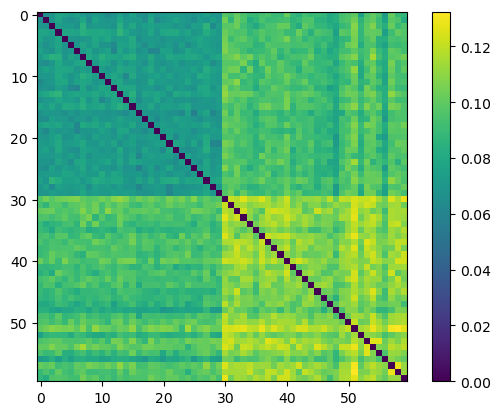

In [130]:
plt.imshow(dist_mat)
plt.colorbar()

/home/nate/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


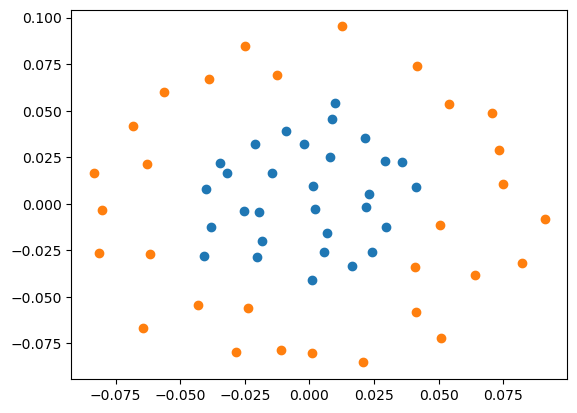

In [131]:

mds = MDS(n_components=2,dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

plt.scatter(vis_data[:p//2,0],vis_data[:p//2,1], color = 'tab:blue')
plt.scatter(vis_data[p//2:,0],vis_data[p//2:,1], color = 'tab:orange')